####  

# Predicting Catalog Demand

#### Max Sydow, Udacity - Predictive Modeling for Business Nanodegree
#### June, 2023

## <u>Business and Data Understanding</u>

#### One way that a high-end home goods manufacturer generates revenue is through catalog purchases.  The company has kept demographic and past sales data, and has used this to calculate likelihood for a customer to make a purchase whether or not they responded to the catalog.  Another dataset for 250 new customers, who have not yet had a chance to respond to the catalog contains the same demographic data, and columns for the probability of them buying from the catalog as it would impossible to inlcude of them already having done so.  Management requested a newly acquired analyst to help decide whether issuing catalogs to these new customers would be worthwhile, and has determined that an expected net profit of $10,000 would need to be exceded in order to make this decision.

#### The data from existing catalog receiving customers can be used to predict sales using other attributes in a linear model.  Graphical exploration of trends for potential predictor variables, and mathematical indicators describing strength of fit and probability of impact on outcome can be used to determine the best model to make these predictions.  Profit margin, the cost of printing catalogs, and the likelihood for catalog purchase can then be used to calculate the final overall expected profit.  

# Existing Customer Data Exploration and Predictive Variable Determination.

#### Existing customer data was read in from an Excel file as a csv named 'p1-customers'.  The data for prospective customers will be loaded later, but was named 'p1-mailinglist'.

In [1]:
# read initial data set, store as dataframe, and load analytic and visualization libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
cust_df = pd.read_csv('p1-customers.csv')

In C:\Users\maxgs\Anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The savefig.frameon rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.
In C:\Users\maxgs\Anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The verbose.level rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.
In C:\Users\maxgs\Anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The verbose.fileo rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.


In [2]:
cust_df.head()

,Name,Customer_Segment,Customer_ID,Address,City,State,ZIP,Avg_Sale_Amount,Store_Number,Responded_to_Last_Catalog,Avg_Num_Products_Purchased,#_Years_as_Customer
0,Pamela Wright,Store Mailing List,2,376 S Jasmine St,Denver,CO,80224,227.90,100,No,1,6
1,Danell Valdez,Store Mailing List,7,12066 E Lake Cir,Greenwood Village,CO,80111,55.00,105,Yes,1,6
2,Jessica Rinehart,Store Mailing List,8,7225 S Gaylord St,Centennial,CO,80122,212.57,101,No,1,3
3,Nancy Clark,Store Mailing List,9,4497 Cornish Way,Denver,CO,80239,195.31,105,Yes,1,6
4,Andrea Brun,Store Mailing List,10,2316 E 5th Ave,Denver,CO,80206,110.55,100,Yes,1,2


In [3]:
# checking size of dataset, and making sure no imputation is needed - each row has the same number of non-null values
cust_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2375 entries, 0 to 2374
Data columns (total 12 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   Name                        2375 non-null   object 
 1   Customer_Segment            2375 non-null   object 
 2   Customer_ID                 2375 non-null   int64  
 3   Address                     2375 non-null   object 
 4   City                        2375 non-null   object 
 5   State                       2375 non-null   object 
 6   ZIP                         2375 non-null   int64  
 7   Avg_Sale_Amount             2375 non-null   float64
 8   Store_Number                2375 non-null   int64  
 9   Responded_to_Last_Catalog   2375 non-null   object 
 10  Avg_Num_Products_Purchased  2375 non-null   int64  
 11  #_Years_as_Customer         2375 non-null   int64  
dtypes: float64(1), int64(5), object(6)
memory usage: 222.8+ KB


#### Look at number of unique values for categorical location variable to determine which, if any, can be used in the model.

In [4]:
cust_df['ZIP'].nunique()

86

In [5]:
cust_df['City'].nunique()

27

In [6]:
cust_df['State'].nunique()

1

#### "ZIP" apears too have too many values for one-hot encoding, while there is only one "State" - neither would be very valuable to have as predictor variables.  Too many predictor variables may lead to overfitting, and become very cumbersome in an equation of fit. "City" has a relatively large number of unique values, but seems like a possible candidate to use in the model.  The below distribution is right-skewed, which may result in some states with higher counts having more influence on the target than others.  I don't beleive this could necessarily be a bad thing, despite the possibility of overfitting - if some states contribute to the prediction according to their p-values, then having such knowledge on location by state influence may be valuable.   

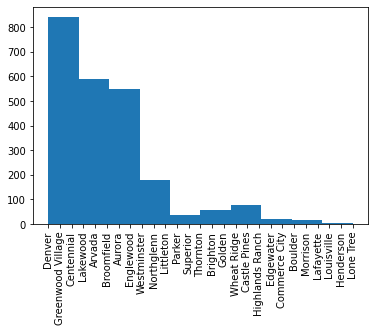

In [7]:
p = plt.hist(cust_df['City'])
plt.xticks(rotation='vertical')
plt.show()

#### "Store_Number" may also turn out to have value in the prediction.  One-hot encoding on 9 values is not too arduous, and the distribution of counts is almost fairly uniform (although store number 102 may not have much sway on the outcome.)

In [8]:
cust_df['Store_Number'].nunique()

10

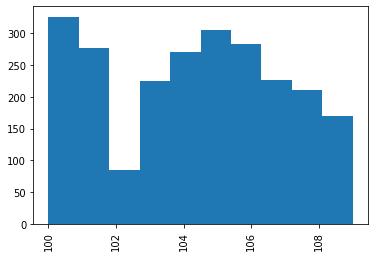

In [9]:
p = plt.hist(cust_df['Store_Number'])
plt.xticks(rotation='vertical')
plt.show()

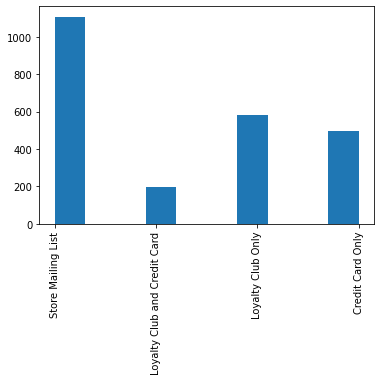

In [10]:
p = plt.hist(cust_df['Customer_Segment'])
plt.xticks(rotation='vertical')
plt.show()

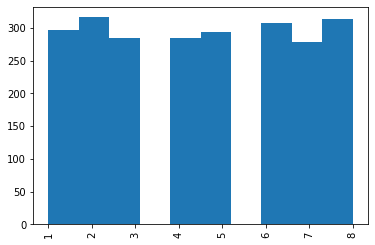

In [11]:
p = plt.hist(cust_df['#_Years_as_Customer'])
plt.xticks(rotation='vertical')
plt.show()

In [12]:
cust_df['#_Years_as_Customer'].value_counts()

2    316
8    313
6    307
1    297
5    294
3    285
4    284
7    279
Name: #_Years_as_Customer, dtype: int64

#### 7 years has the least number of values, so this should be removed if this column were to be treated as a categorical instead of ordinal/continuous variable.

#### The count profile for Customer_Segment may have some skewedness if the x-axis variables were to be re-ordered.  This attribute will be looked into further below, but let's keep it as a potential predictor variable for now.  Since 'Responded_to_Last_Catalog' does not exist in the data set for the new customers, it cannot be used in a model that makes predictions for them.

In [13]:
# remove Name, Customer_ID, Address, State, ZIP
catmod_df = cust_df.drop(['Name', 'Customer_ID', 'Address', 'State', 'ZIP', 'Responded_to_Last_Catalog'], axis=1)

In [14]:
catmod_df.columns

Index(['Customer_Segment', 'City', 'Avg_Sale_Amount', 'Store_Number',
       'Avg_Num_Products_Purchased', '#_Years_as_Customer'],
      dtype='object')

In [15]:
catmod_df.select_dtypes(include='object').nunique()

Customer_Segment     4
City                27
dtype: int64

## Plots and distributions of potentential predictor variables:

#### Looking at scatter-plots of each candidate predictor variable versus the target variable, we see that the average number of products purchased has a roughly linear trend compared to average sale amount.  Number of years as customer is an ordinal variable that can be treated as continuous, but there are only 8 distinct values and the generalized scatter-plot doesn't reveal a clearly visible linear trend at this view level.  This may indicate that this variable will have little or even a negative impact on the model, but examining P-values and R-squared strength of fit would ultimately be better indicators for such a determination.  

#### Looking at the other categorical variables as grouped boxplots ordered by median average sales can aid in visually identifying trends, and may give an indication of how outliers may sway a prediction.  Observing similarly ordered trends in mean sales may also be useful for this reason.

#### Overall set of scatter-plots

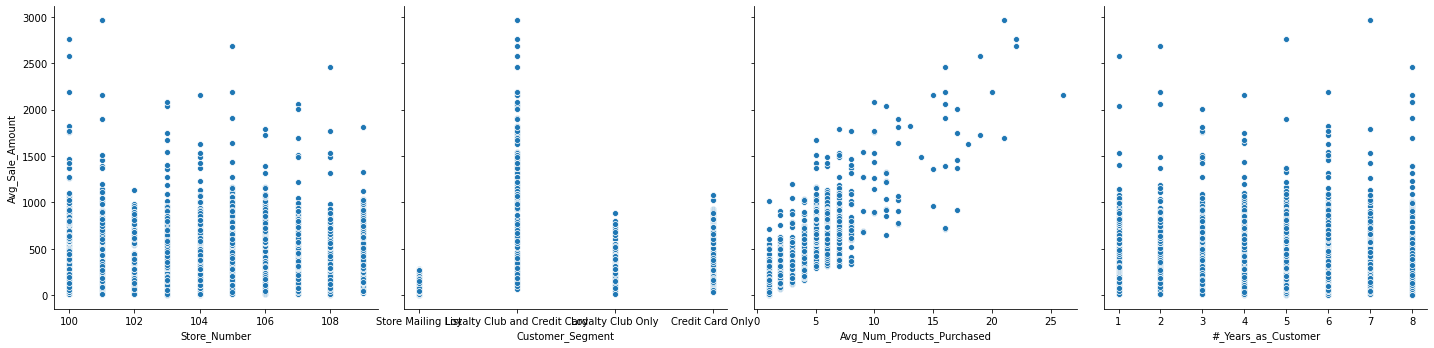

In [16]:
g = sns.PairGrid(catmod_df, y_vars=["Avg_Sale_Amount"], x_vars=['Store_Number', 'Customer_Segment',
       'Avg_Num_Products_Purchased', '#_Years_as_Customer'], height=5)
g.map(sns.scatterplot)

#### City

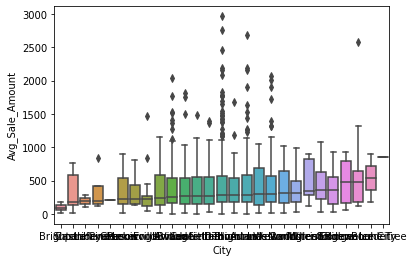

In [17]:
# boxplots of ordered (low-to-high) mean Avg_Sale_Amount by City
city_meds=catmod_df.groupby(['City'])['Avg_Sale_Amount'].median().sort_values(ascending=True)
sns.boxplot(x='City', y='Avg_Sale_Amount', data=catmod_df, order=city_meds.index)

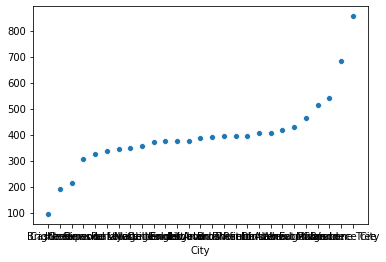

In [18]:
# plot of ordered (increasing) aggregated mean average sales by City
X_city=catmod_df.groupby(['City'])['Avg_Sale_Amount'].mean().sort_values(ascending=True).index
Y_city=catmod_df.groupby(['City'])['Avg_Sale_Amount'].mean().sort_values(ascending=True).values

sns.scatterplot(x=X_city, y=Y_city)

#### While not an ordinal variable in it's own right, the average of 'Avg_Sale_Amount' appears to follow an inverse or even cubic trend when ordered from least to most when plotted against 'City'.  However, most of the y-values appear to hover about a horizontal line about y=400.  This may indicate a more or less even distribution of aggregated sales amidst all of the cities in the sampled data, thereby nullifying it's effect on making a prediction.

#### Store_Number

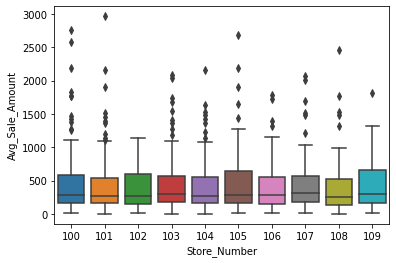

In [19]:
# boxplots of ordered (low-to-high) mean Avg_Sale_Amount by Store_Number
storenum_meds=catmod_df.groupby(['Store_Number'])['Avg_Sale_Amount'].median()
sns.boxplot(x='Store_Number', y='Avg_Sale_Amount', data=catmod_df)

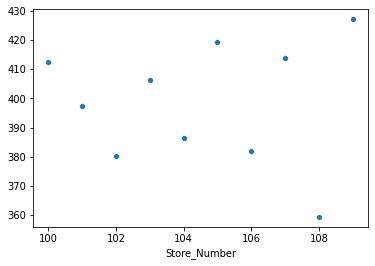

In [20]:
# plot aggregated mean average sales vs. (increasing) ordered store number
X=catmod_df.groupby(['Store_Number'])['Avg_Sale_Amount'].mean().sort_values(ascending=True).index
Y=catmod_df.groupby(['Store_Number'])['Avg_Sale_Amount'].mean().sort_values(ascending=True).values

sns.scatterplot(x=X, y=Y)

#### Aggregated average sales appears to disperse further as the 'Store_Number' increases in numerical value.  This effect would only widen a residual error for line of fit.

#### Customer_Segment

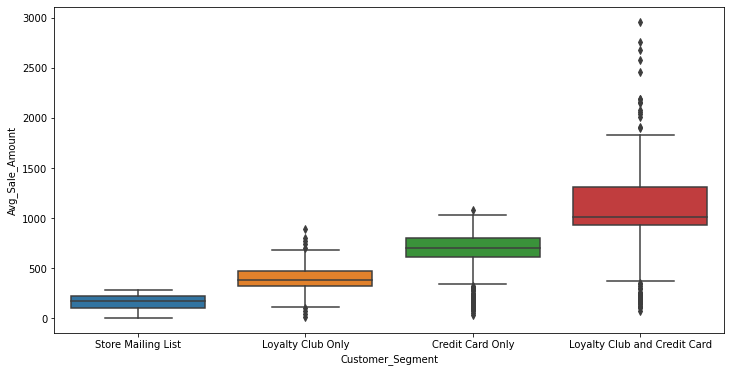

In [21]:
# looks the way I want it regardless of errors, check above for accuracy
custseg_medss=catmod_df.groupby(['Customer_Segment'])['Avg_Sale_Amount'].median().sort_values(ascending=True)
fig,ax = plt.subplots(figsize=(12,6))
sns.boxplot(x='Customer_Segment', y='Avg_Sale_Amount', data=catmod_df, order=custseg_medss.index)
#ax.set_xticklables(ax.get_xticklabels(), rotation=45)
plt.show()

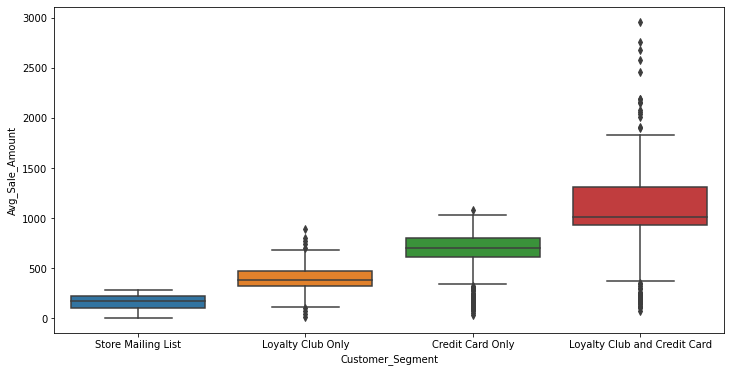

In [22]:
# looks the way I want it regardless of errors, check above for accuracy
custseg_medss=catmod_df.groupby(['Customer_Segment'])['Avg_Sale_Amount'].median().sort_values(ascending=True)
fig,ax = plt.subplots(figsize=(12,6))
sns.boxplot(x='Customer_Segment', y='Avg_Sale_Amount', data=catmod_df, order=custseg_medss.index)
#ax.set_xticklables(ax.get_xticklabels(), rotation=45)
plt.show()

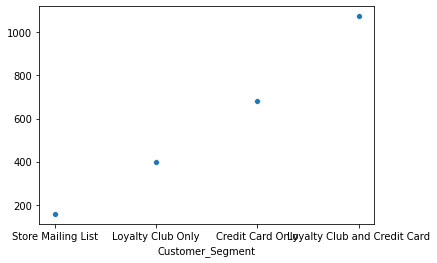

In [23]:
# plot aggregated mean average sales (ordered increasing) by Customer_Segment
X=catmod_df.groupby(['Customer_Segment'])['Avg_Sale_Amount'].mean().sort_values(ascending=True).index
Y=catmod_df.groupby(['Customer_Segment'])['Avg_Sale_Amount'].mean().sort_values(ascending=True).values

sns.scatterplot(x=X, y=Y)

#### There is a clear increasing trend for both median and mean aggragated 'Avg_Sales_Amounts' when plotted in an increasing order grouped by Customer_Segment'.  The four categories along the x-axis are absolutely categorical, and not ordinal or continous at all, however, when plotted this way, it is hard to deny the appearance of an overall visual trend that may have a positive slope! 

#### If this observation could indicate an impact on a multi-variable linear model, then we should still resort to utilizing P-values and fit-measures to reach such a conclusion.  

#### Years as Customer

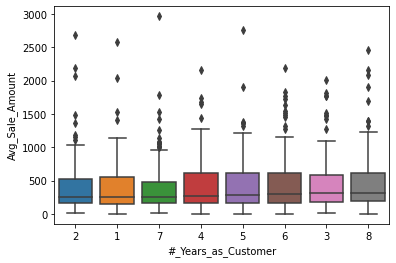

In [24]:
# boxplots of ordered (low-to-high) mean Avg_Sale_Amount by #_Years_as_Customer
custyrs_meds=catmod_df.groupby(['#_Years_as_Customer'])['Avg_Sale_Amount'].median().sort_values(ascending=True)
sns.boxplot(x='#_Years_as_Customer', y='Avg_Sale_Amount', data=catmod_df, order=custyrs_meds.index)

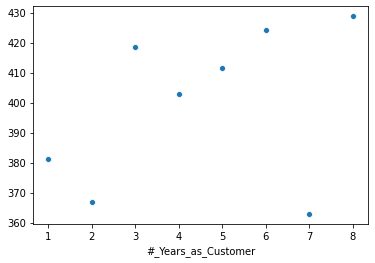

In [25]:
# plot aggregated mean average sales vs. (increasing) ordered #_Years_as_Customer
X=catmod_df.groupby(['#_Years_as_Customer'])['Avg_Sale_Amount'].mean().sort_values(ascending=True).index
Y=catmod_df.groupby(['#_Years_as_Customer'])['Avg_Sale_Amount'].mean().sort_values(ascending=True).values

sns.scatterplot(x=X, y=Y)

#### The overall median 'Avg_Sale_Amount' appears to disperse as '#_Years_as_Cusomer' increases, but also appears to follow a general increasing trend if 2 and 7 were eliminated as outliers.

#### If the last two observations could indicate an impact on a multi-variable linear model, then we should still resort to utilizing P-values and fit-measures to reach such a conclusion.  

#### The average sales means and inter-quartile ranges for store number and years as customer are fairly uniform, while there is more variation amongst cities and customer segment.  These plots can provide a visual indication of outliers with respect to average sales for each value in respective columns, but an outlier for one particular value may not overlap as an outlier for another.  Removing rows contianing outliers may lead to improved model accuracy, but to remove rows of data based on this way of finding outliers may result in removing values for which outliers do not occur in other columns.   Rather, the lack of linear trend in the mean for each of these columns may indicate poor contribution to the model in a similar way discussed above. 

## Transforming Categorical Variables for Suitable Use in a Mathematical Linear Model:
### One-Hot-Encoding Dummy Variables:

#### The term "cardinality" in this context, refers to the number of unique values in any particular catagorical column of a dataset.  The "size" of a finite mathematical set can also be described using this term, which comes along with an attached stipulation that there exists a one-to-one mapping with another set and thereby implies equivalent sizes and quantities of unique elements across the mapping between such sets.  Before attempting to launch into a much deeper formalization of this loosely paraphrased logical reduction, it hopefully won't seem to be too much of a stretch of imagination or intuition to arrive at the conclusion that cardinality can be encoded.  This is to say that each distinct value of a finite, categorical column can be described in binary terms!  In this way each uniquely individual element of a field/variable/column/set can be re-allocated to a 'yes' or 'no' value!  If the unique value exists within a given row, then a new column can be created with the name of that very same unique (old) value, then re-assigned a new binary-valued set of values depending on whether it appears in that particular row.  

#### In more practical terms this means that if a generalized customer behaviorial column can be defined such as "Segment" = "Loyalty" for a uniquely indexed row, then a new column called "Loyalty" can be added to the dataset that contains a discrete integer value of either 0 or 1 according to the row index for which that exact and particular value appeared in.  The same can be applied to the other unique 3-values in this column, since it has a cardinality of 4.   However, if one of the new 4 columns contained a 1 then, then the other 3 must contain 0s, which wouldn't really serve any value in any circumstance.  One of these new columns of binary values can be dropped, while simultaneously the former, more linguistically descriptive column is no longer necessary.  

#### Aside from the applicable, yet still vague mathematical translation of concepts, the undertaking of such logical manipulations would otherwise require a much more lengthy procedural and algorithmic manipulation of data structures to acheive this seemingly simplistically represented end result.   The re-organizing of basic elements into categories in this way would require a type of if-then sorting filter, which would further need to be performed again and again in a finite loop along with a kind of drop-replace kind of queue-like mechanism.  This kind of loop-sort algorithm would also need to be applied to find and sort the remainder of the other unique values within just that one column.  In order to apply this procedure to the other columns it would seem to be quite beneficial to be able to re-apply this already complicated logic to other similarly organized columns.  

#### Thankfully, many other brilliant minds have done a lot of hard work to conceptualize these kinds of abstract concepts in order to formulate such fundamental and procedural operations into manipulatable classes of objects which were passed down and made usable to others through various forms of linguistically manipulated syntax!  Such usable objects or functions now have some more general, but specific parameters to specify in order to acheive a certain realm of outcomes in order to compute a general range of output from a broader range of more result oriented users.  Packages containing such usable functions are available in Python and used here for one-hot-encoding and linear model building.  Visual icons could then be created to represent various operations so that a broader range of user could drop and drag onto a fairly appealling looking visual interface, such as that used in the Alteryx platform, in order to completely automate a brand new workflow in order to extract, transform and load newly transformed data, then output it into another application so that it could be manipulated even further.

In [26]:
# import package for ordinary-least-squares model creation and analysis
from statsmodels.formula.api import ols

In [27]:
# this version of Python and modeling package did not like "#" in a column name, and saw it as a special character
catmod_df.rename(columns={'#_Years_as_Customer': 'Years_as_Customer'}, inplace=True)

#### The below code performs one-hot encoding on categorical columns.  Assuming there are no null values to begin with, which there are, then a row which does not contain a value of '1' for any of the (n-1) encoded columns it must contain a 1 for the nth coded column.  An easy way to adjust for this is to simply drop the last encoded column, which for "City", is "Wheat Ridge".   

In [54]:
city_ohe = pd.get_dummies(catmod_df['City'])
catmod_df_2 = catmod_df.join(city_ohe)
catmod_df_2.drop(['City'], axis=1, inplace=True)
catmod_df_2.drop(['Wheat Ridge'], axis=1, inplace = True)
catmod_df_2.head()

,Customer_Segment,Avg_Sale_Amount,Store_Number,Avg_Num_Products_Purchased,Years_as_Customer,Arvada,Aurora,Boulder,Brighton,Broomfield,...,Lakewood,Littleton,Lone Tree,Louisville,Morrison,Northglenn,Parker,Superior,Thornton,Westminster
0,Store Mailing List,227.90,100,1,6,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,Store Mailing List,55.00,105,1,6,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,Store Mailing List,212.57,101,1,3,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,Store Mailing List,195.31,105,1,6,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,Store Mailing List,110.55,100,1,2,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [56]:
storenum_ohe = pd.get_dummies(catmod_df_2['Store_Number'])
catmod_df_3 = catmod_df_2.join(storenum_ohe)
catmod_df_3.drop(['Store_Number'], axis=1, inplace=True)
catmod_df_3.drop([100], axis=1, inplace = True)
catmod_df_3.head()

,Customer_Segment,Avg_Sale_Amount,Avg_Num_Products_Purchased,Years_as_Customer,Arvada,Aurora,Boulder,Brighton,Broomfield,Castle Pines,...,Westminster,101,102,103,104,105,106,107,108,109
0,Store Mailing List,227.90,1,6,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,Store Mailing List,55.00,1,6,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
2,Store Mailing List,212.57,1,3,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
3,Store Mailing List,195.31,1,6,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
4,Store Mailing List,110.55,1,2,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [57]:
custseg_ohe = pd.get_dummies(catmod_df_3['Customer_Segment'])
catmod_df_4 = catmod_df_3.join(custseg_ohe)
catmod_df_4.drop(['Customer_Segment'], axis=1, inplace=True)
# dropping 'Credit Card Only' as the base case
catmod_df_4.drop(['Credit Card Only'], axis=1, inplace=True)
catmod_df_4.head()

,Avg_Sale_Amount,Avg_Num_Products_Purchased,Years_as_Customer,Arvada,Aurora,Boulder,Brighton,Broomfield,Castle Pines,Centennial,...,103,104,105,106,107,108,109,Loyalty Club Only,Loyalty Club and Credit Card,Store Mailing List
0,227.90,1,6,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1,55.00,1,6,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,1
2,212.57,1,3,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,1
3,195.31,1,6,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,1
4,110.55,1,2,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


In [62]:
catmod_df_4.rename(columns={'Castle Pines' : 'Castle_Pines', 'Commerce City' : 'Commerce_City', 
                          'Greenwood Village' : 'Greenwood_Village', 'Highlands Ranch' : 'Highlands_Ranch',
                          'Lone Tree': 'Lone_Tree', 101 : 'OneHundredOne', 102 : 'OneHundredTwo',
                          103 : 'OneHundredThree', 104 : 'OneHundredFour',
                          105 : 'OneHundredFive', 106 : 'OneHundredSix', 107 : 'OneHundredSeven', 
                          108 : 'OneHundredEight', 109 : 'OneHundredNine', 'Loyalty Club Only' : 'Loyalty_Club_Only',
                          'Loyalty Club and Credit Card' : 'Loyalty_Club_and_Credit_Card',
                          'Store Mailing List' : 'Store_Mailing_List'}, inplace=True)

In [63]:
catmod_df_4.columns

Index(['Avg_Sale_Amount', 'Avg_Num_Products_Purchased', 'Years_as_Customer',
       'Arvada', 'Aurora', 'Boulder', 'Brighton', 'Broomfield', 'Castle_Pines',
       'Centennial', 'Commerce_City', 'Denver', 'Edgewater', 'Englewood',
       'Golden', 'Greenwood_Village', 'Henderson', 'Highlands_Ranch',
       'Lafayette', 'Lakewood', 'Littleton', 'Lone_Tree', 'Louisville',
       'Morrison', 'Northglenn', 'Parker', 'Superior', 'Thornton',
       'Westminster', 'OneHundredOne', 'OneHundredTwo', 'OneHundredThree',
       'OneHundredFour', 'OneHundredFive', 'OneHundredSix', 'OneHundredSeven',
       'OneHundredEight', 'OneHundredNine', 'Loyalty_Club_Only',
       'Loyalty_Club_and_Credit_Card', 'Store_Mailing_List'],
      dtype='object')

# Finding the best Ordinary-Least-Squares (OLS) model.

#### When first attempting to create the model, Python did not like having column names with spaces or numeric column names.  Replacing spaces with underscores and integers with the word representations of the last digit will alleviate this syntax related impediment.

### Now, an initial ordinary-least-squares model can be created.

In [64]:
lin_mdl_v1 = ols('Avg_Sale_Amount ~ Avg_Num_Products_Purchased + Years_as_Customer + Arvada + Aurora + Boulder + Brighton + Broomfield + Castle_Pines + Centennial + Commerce_City + Denver + Edgewater + Englewood + Golden + Greenwood_Village + Henderson + Highlands_Ranch + Lafayette + Lakewood + Littleton + Lone_Tree + Louisville + Morrison + Northglenn + Parker + Superior + Thornton + Westminster  + OneHundredOne + OneHundredTwo + OneHundredThree + OneHundredFour + OneHundredFive + OneHundredSix + OneHundredSeven + OneHundredEight + OneHundredNine + Loyalty_Club_Only + Loyalty_Club_and_Credit_Card + Store_Mailing_List' 
                ,data = catmod_df_4).fit()

In [65]:
lin_mdl_v1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:        Avg_Sale_Amount   R-squared:                       0.839
Model:                            OLS   Adj. R-squared:                  0.836
Method:                 Least Squares   F-statistic:                     304.5
Date:                Wed, 28 Jun 2023   Prob (F-statistic):               0.00
Time:                        10:28:29   Log-Likelihood:                -15044.
No. Observations:                2375   AIC:                         3.017e+04
Df Residuals:                    2334   BIC:                         3.041e+04
Df Model:                          40                                         
Covariance Type:            nonrobust                                         
================================================================================================
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
Intercept                      338.7096     24.314     13.931      0.000     291.031     386.389
Avg_Num_Products_Purchased      67.1014      1.529     43.877      0.000      64.102      70.100
Years_as_Customer               -2.5182      1.238     -2.035      0.042      -4.945      -0.091
Arvada                         -14.4721     21.508     -0.673      0.501     -56.650      27.705
Aurora                         -28.6447     22.863     -1.253      0.210     -73.478      16.189
Boulder                        -80.8697     83.149     -0.973      0.331    -243.923      82.183
Brighton                       -99.9198     99.786     -1.001      0.317    -295.597      95.758
Broomfield                     -33.3995     24.799     -1.347      0.178     -82.030      15.231
Castle_Pines                  -112.6033    101.284     -1.112      0.266    -311.219      86.012
Centennial                     -18.2795     26.900     -0.680      0.497     -71.030      34.471
Commerce_City                  -46.9168     47.948     -0.979      0.328    -140.941      47.108
Denver                          -9.0915     20.235     -0.449      0.653     -48.772      30.589
Edgewater                       23.8318     44.053      0.541      0.589     -62.555     110.219
Englewood                       -2.8789     27.458     -0.105      0.917     -56.723      50.966
Golden                         -21.0606     36.815     -0.572      0.567     -93.254      51.133
Greenwood_Village              -59.3263     42.620     -1.392      0.164    -142.904      24.252
Henderson                     -288.2340    139.176     -2.071      0.038    -561.156     -15.312
Highlands_Ranch                -36.5585     35.621     -1.026      0.305    -106.410      33.293
Lafayette                      -70.1643     65.340     -1.074      0.283    -198.296      57.967
Lakewood                       -13.2208     21.682     -0.610      0.542     -55.739      29.297
Littleton                      -36.5494     26.422     -1.383      0.167     -88.362      15.263
Lone_Tree                       71.7791    139.692      0.514      0.607    -202.154     345.712
Louisville                     -63.1000     72.421     -0.871      0.384    -205.117      78.917
Morrison                       -22.9778     55.933     -0.411      0.681    -132.662      86.706
Northglenn                     -39.5466     34.809     -1.136      0.256    -107.807      28.714
Parker                         -24.8182     37.359     -0.664      0.507     -98.078      48.441
Superior                       -85.7841     50.909     -1.685      0.092    -185.616      14.048
Thornton                         5.0410     31.124      0.162      0.871     -55.992      66.074
Westminster                    -29.7394     25.350     -1.173      0.241    

### This initial model resulted in a pretty good fit with an R-squred of 0.839, but could possibly be improved.  Any predictor variable with a p-statistic greater than 0.05 can be removed.  Errors for each coefficient and the y-intercept can be calculated using the sum of squared errors from mean for each value, and the their sum.  The distribution of each type of error would ideally follow a normal distribution, and a hypothetical mean can be proposed which adheres to this.  A null hypothesis on the intercept error can be made that says an X variable has no influence on Y.  A t-statistic can then be calculated from the difference of actual and hypothetical means, and then used to rule out the hypothesis.  The p-value for each variable is the probability of obtaining a t-statistic that is least likely to contradict the null-hypothesis.  Hence, any variable with a p-value close to 0 indicates that a variable is more likely to contradict the hypothesis and should be kept in the model.  A reasonable cutoff of 0.05 would then indicate that such a variable likely has no influence on the target.  

### Average number of products purchased and years as customer meet this criteria.  A roughly linear relationship between number of products purchased and sales was seen earlier, so it makes sense that these variables would influence a sales prediction.  Years as customer did not reveal such a linear trend, but it is being treated as an ordinal, numeric and continuous predictive variable and so it's significance on the outcome may not be that surprising.  The 3 encoded customer segments are also statistically likely to influence the sales prediction.   Location related descriptors such as city and store number had no significant impact on the prediction, with the exception onfone particular city.  

#### Even though the encoded column for the city of Henderson is significant according to P-value, it doesn't make much sense to keep this one city in the model, given that the others did not have an impact and especially since only one customer row contains a "1" for this column.

In [67]:
catmod_df_4['Henderson'].value_counts()

0    2374
1       1
Name: Henderson, dtype: int64

In [66]:
# keeping predictor variables, for which p <= 0.05
# refined model
lin_mdl_v2 = ols('Avg_Sale_Amount ~ Avg_Num_Products_Purchased + Years_as_Customer + Loyalty_Club_Only + Loyalty_Club_and_Credit_Card + Store_Mailing_List' 
                ,data = catmod_df_4).fit()

In [68]:
lin_mdl_v2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:        Avg_Sale_Amount   R-squared:                       0.837
Model:                            OLS   Adj. R-squared:                  0.837
Method:                 Least Squares   F-statistic:                     2435.
Date:                Wed, 28 Jun 2023   Prob (F-statistic):               0.00
Time:                        10:29:16   Log-Likelihood:                -15059.
No. Observations:                2375   AIC:                         3.013e+04
Df Residuals:                    2369   BIC:                         3.016e+04
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
================================================================================================
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
Intercept                      313.7602     11.861     26.454      0.000     290.502     337.019
Avg_Num_Products_Purchased      67.0183      1.514     44.255      0.000      64.049      69.988
Years_as_Customer               -2.3401      1.223     -1.914      0.056      -4.738       0.058
Loyalty_Club_Only             -149.1067      8.969    -16.625      0.000    -166.694    -131.519
Loyalty_Club_and_Credit_Card   282.6215     11.910     23.729      0.000     259.266     305.977
Store_Mailing_List            -245.4831      9.762    -25.146      0.000    -264.627    -226.339
==============================================================================
Omnibus:                      360.046   Durbin-Watson:                   2.040
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             4782.949
Skew:                           0.232   Prob(JB):                         0.00
Kurtosis:                       9.937   Cond. No.                         36.2
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

#### R-squared lessened by a very small amount, but now Years_as_Customer should be removed according to its P-value.

In [69]:
# refined model
lin_mdl_v3 = ols('Avg_Sale_Amount ~ Avg_Num_Products_Purchased + Loyalty_Club_Only + Loyalty_Club_and_Credit_Card + Store_Mailing_List' 
                ,data = catmod_df_4).fit()

In [45]:
lin_mdl_v3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:        Avg_Sale_Amount   R-squared:                       0.837
Model:                            OLS   Adj. R-squared:                  0.837
Method:                 Least Squares   F-statistic:                     3040.
Date:                Wed, 28 Jun 2023   Prob (F-statistic):               0.00
Time:                        10:22:17   Log-Likelihood:                -15061.
No. Observations:                2375   AIC:                         3.013e+04
Df Residuals:                    2370   BIC:                         3.016e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
================================================================================================
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
Intercept                      303.4635     10.576     28.694      0.000     282.725     324.202
Avg_Num_Products_Purchased      66.9762      1.515     44.208      0.000      64.005      69.947
Loyalty_Club_Only             -149.3557      8.973    -16.645      0.000    -166.951    -131.760
Loyalty_Club_and_Credit_Card   281.8388     11.910     23.664      0.000     258.484     305.194
Store_Mailing_List            -245.4177      9.768    -25.125      0.000    -264.572    -226.263
==============================================================================
Omnibus:                      359.638   Durbin-Watson:                   2.045
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             4770.580
Skew:                           0.232   Prob(JB):                         0.00
Kurtosis:                       9.928   Cond. No.                         25.0
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### This final model has only significantly contributing predictor variables and a fairly strong fit with an R-squared of 0.837.  

### The equation of fit for the final model is:

### Y = 66.98X1 - 149.36X2 + 281.84X3 - 245.42X4 + 303.46, where
####   Y: average sale amount for a customer
####  X1:  average number of products purchased
#### X2: loyalty club only
#### X3: loyalty club and credit card
#### X4: store mailing list

### In other words, average sales and customer segment are the only influential colums to predict new sales according to this model.

# Applying the model to make predictions for new customers.

### This final model has only significantly contributing predictor variables and a fairly strong fit with an R-squared of 0.837.  

### The equation of fit for the final model is:

### Y = 66.98X1 - 149.36X2 + 281.84X3 - 245.42X4 + 303.46
###  , where
####   Y: average sale amount for a customer
####  X1:  average number of products purchased
#### X2: loyalty club only
#### X3: loyalty club and credit card
#### X4: store mailing list

### In other words, average sales and customer segment are the only influential colums to predict new sales according to this model.

#### The second data set containing catalog response probability needs to be loaded.

In [70]:
revpred_df = pd.read_csv('p1-mailinglist.csv')

#### Since Customer_Segment appears in a one-hot-encoded format in the model, we need to make the same transformation in the new dataset in order to use the equation of fit to calculate predicted sales.

In [71]:
custseg_ohe2 = pd.get_dummies(revpred_df['Customer_Segment'])
revpred_df_2 = revpred_df.join(custseg_ohe)

In [72]:
revpred_df_2.rename(columns={'Loyalty Club Only' : 'Loyalty_Club_Only',
                          'Loyalty Club and Credit Card' : 'Loyalty_Club_and_Credit_Card',
                          'Store Mailing List' : 'Store_Mailing_List' }, inplace=True)

In [73]:
revpred_df_2.columns

Index(['Name', 'Customer_Segment', 'Customer_ID', 'Address', 'City', 'State',
       'ZIP', 'Store_Number', 'Avg_Num_Products_Purchased',
       '#_Years_as_Customer', 'Score_No', 'Score_Yes', 'Credit Card Only',
       'Loyalty_Club_Only', 'Loyalty_Club_and_Credit_Card',
       'Store_Mailing_List'],
      dtype='object')

#### Using the ols equation we can add a new column containing predicted sales for each potential customer. 

In [74]:
# new column for predicted revenue
revpred_df_2['PredSales'] = 66.98*revpred_df_2.Avg_Num_Products_Purchased - 149.36*revpred_df_2.Loyalty_Club_Only + 281.84*revpred_df_2.Loyalty_Club_and_Credit_Card - 245.42*revpred_df_2.Store_Mailing_List + 303.46

#### Expected revenue from predicted sales depends on the probability of each new customer purchasing a catalog.

In [75]:
revpred_df_2['ExpRev'] = revpred_df_2.PredSales*revpred_df_2.Score_Yes

#### Now we need to take into account the gross margin (price - cost) on catalog sales, which is 50% per customer, then subtract catalog costs.

In [76]:
# computing new column for predicted profit margin per customer
revpred_df_2['PredProfit'] = 0.5*revpred_df_2.ExpRev - 6.5

In [78]:
revpred_df_2.head()

,Name,Customer_Segment,Customer_ID,Address,City,State,ZIP,Store_Number,Avg_Num_Products_Purchased,#_Years_as_Customer,Score_No,Score_Yes,Credit Card Only,Loyalty_Club_Only,Loyalty_Club_and_Credit_Card,Store_Mailing_List,PredSales,ExpRev,PredProfit
0,A Giametti,Loyalty Club Only,2213,5326 S Lisbon Way,Centennial,CO,80015,105,3,0.2,0.694964,0.305036,0,0,0,1,258.98,78.998173,32.999087
1,Abby Pierson,Loyalty Club and Credit Card,2785,4344 W Roanoke Pl,Denver,CO,80236,101,6,0.6,0.527275,0.472725,0,0,0,1,459.92,217.415469,102.207735
2,Adele Hallman,Loyalty Club Only,2931,5219 S Delaware St,Englewood,CO,80110,101,7,0.9,0.421118,0.578882,0,0,0,1,526.90,305.012847,146.006423
3,Alejandra Baird,Loyalty Club Only,2231,2301 Lawrence St,Denver,CO,80205,103,2,0.6,0.694862,0.305138,0,0,0,1,192.00,58.586460,22.793230
4,Alice Dewitt,Loyalty Club Only,2530,5549 S Hannibal Way,Centennial,CO,80015,104,4,0.5,0.612294,0.387706,0,0,0,1,325.96,126.376600,56.688300


### Finally, we can sum the predicted profit for each customer to see if issuing catalogs could be deemed worthwhile.

In [77]:
Total = revpred_df_2['PredProfit'].sum()
print("The predicted net return from new catalog issues is: $", round(Total,2))

The predicted net return from new catalog issues is: $ 14258.73


## The net expected profit from sending a catalog to these new customers exceeds the established threshold! The linear model obtained from analysis on variation within existing customer data resulted in new sales predictions with a strong level of accuracy.   Even when factoring in the liklihood of making a purchase from a catalog, the gross margin of price vs cost differential on products produced, and catolog printing and distribution costs the effort of issuing catalogs to these 250 new customers exceeds expectations by at least $4K.  The analyst who performed this work would recommend sending out catalogs to the new sample of welcomed and appreciated customers.